# UNFINISHED - Multi-task learning with synthetic data

Can we fit a model to multiple targets to improve performance on a tabular learning example?

Todo:
1. Generate data
2. Build base learners
   1. GBM
   2. Dense neural network
3. Build multi task learners
   1. Shared layers, with split layers per task
4. Explore the combination of metrics

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl

plt.style.use("seaborn-v0_8-whitegrid")
pl.Config.set_fmt_str_lengths(30)

polars.config.Config

## Generate data

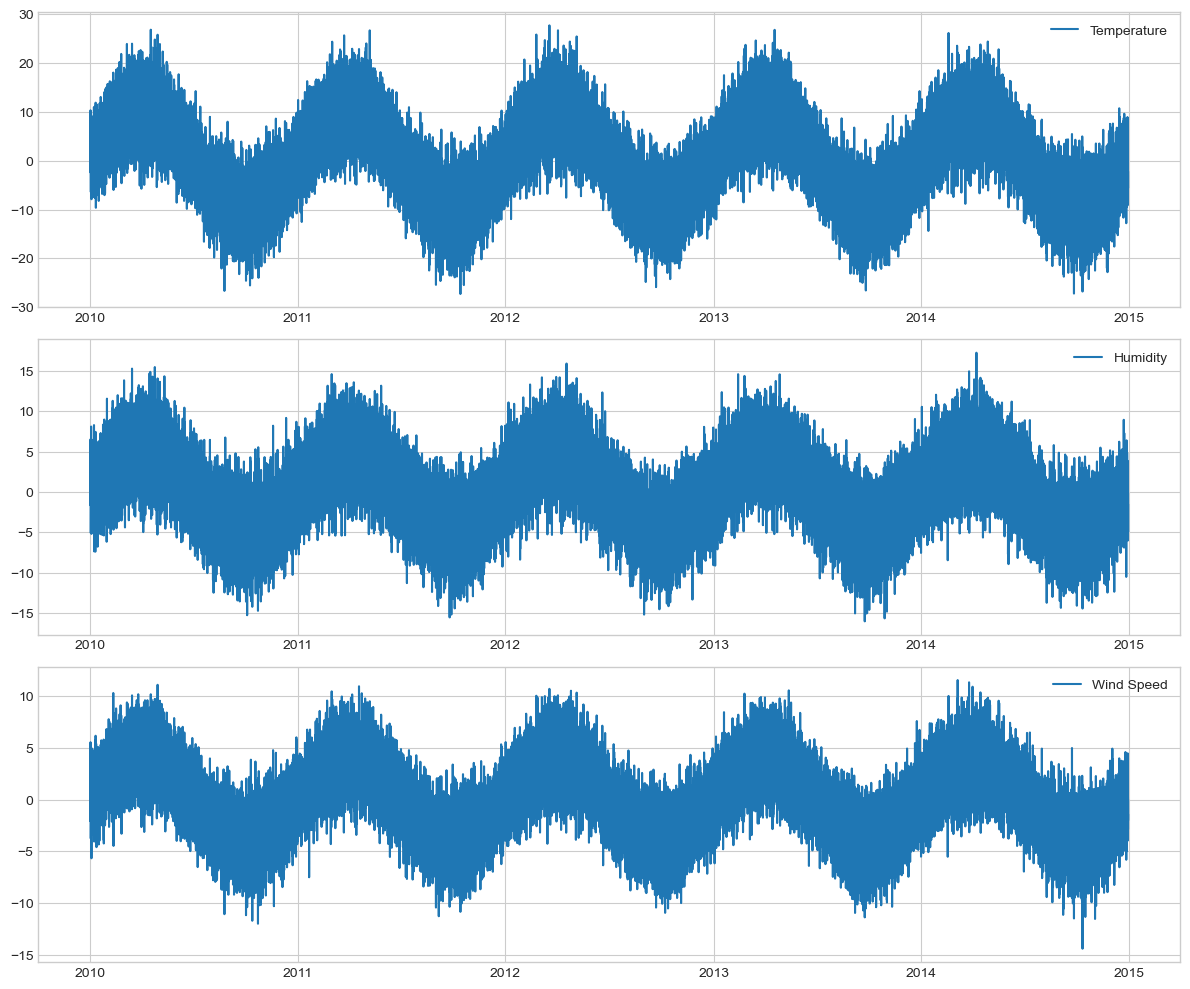

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
n_years = 5
freq = "H"  # Hourly data
n_samples = int(n_years * 365 * 24)  # Number of samples
n_lags = 5
n_series = 3

# Create datetime index
date_range = pd.date_range(start="2010-01-01", periods=n_samples, freq=freq)

# Generate yearly and daily sinusoidal patterns
yearly_pattern = np.sin(2 * np.pi * date_range.dayofyear / 365.25)
daily_pattern = np.sin(2 * np.pi * date_range.hour / 24)

# Generate time series data with noise on top of the sinusoidal patterns
# need to 0 center to avoid bias learning taking all the training time
np.random.seed(42)
temperature_yearly_scale = 10
temperature_daily_scale = 5
temperature = (
    (temperature_yearly_scale + np.random.normal(0, 3, n_samples)) * yearly_pattern
    + (temperature_daily_scale + np.random.normal(0, 3, n_samples)) * daily_pattern
    + np.random.normal(0, 1, n_samples)
    # +10
)
humidity = 0.5 * temperature + np.random.normal(0, 2, n_samples)  # +50
wind_speed = (
    0.3 * temperature + 0.2 * humidity + np.random.normal(0, 1, n_samples)
)  # + 10


df = pd.DataFrame(
    {
        "datetime": date_range,
        "temperature": temperature,
        "humidity": humidity,
        "wind_speed": wind_speed,
    }
)


plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(df["datetime"], df["temperature"], label="Temperature")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df["datetime"], df["humidity"], label="Humidity")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df["datetime"], df["wind_speed"], label="Wind Speed")
plt.legend()

plt.tight_layout()
plt.show()

In [3]:
def create_lags(df, lags):
    df = df.copy()
    for col in df.columns:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df


lags = [1, 2, 5, 10, 24, 48, 72, 96]
df_lagged = pd.concat(
    [df["datetime"], create_lags(df.drop(columns=["datetime"]), lags)], axis=1
)
df_lagged = df_lagged.dropna().reset_index(drop=True)


X = df_lagged.drop(columns=["datetime", "temperature", "humidity", "wind_speed"]).values
y = df_lagged[["temperature", "humidity", "wind_speed"]].values

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
df_lagged

X shape: (43704, 24)
y shape: (43704, 3)


,datetime,temperature,humidity,wind_speed,temperature_lag_1,temperature_lag_2,temperature_lag_5,temperature_lag_10,temperature_lag_24,temperature_lag_48,...,humidity_lag_72,humidity_lag_96,wind_speed_lag_1,wind_speed_lag_2,wind_speed_lag_5,wind_speed_lag_10,wind_speed_lag_24,wind_speed_lag_48,wind_speed_lag_72,wind_speed_lag_96
0,2010-01-05 00:00:00,-0.853069,2.532848,-2.165002,0.287606,-3.892065,-5.669995,-4.451557,1.020907,2.389386,...,1.388811,-0.597493,0.474319,-3.155223,-2.781332,-0.416429,3.214044,1.738935,1.007183,-2.071950
1,2010-01-05 01:00:00,-0.481367,-1.421058,-2.336929,-0.853069,0.287606,-1.424698,1.263881,2.517986,1.814361,...,1.019509,3.827570,-2.165002,0.474319,-0.975336,1.435989,0.419065,0.783738,1.780980,0.022919
2,2010-01-05 02:00:00,4.752071,3.590725,0.807195,-0.481367,-0.853069,-0.132352,-0.872985,1.714415,1.823185,...,0.590583,2.630381,-2.336929,-2.165002,-1.034602,0.448455,2.294831,1.386325,2.132477,1.179135
3,2010-01-05 03:00:00,3.691398,1.480955,1.201990,4.752071,-0.481367,-3.892065,-4.397168,9.037914,2.667136,...,1.662739,6.171063,0.807195,-2.336929,-3.155223,-1.919503,3.225172,-0.195374,1.340059,3.083729
4,2010-01-05 04:00:00,2.957130,3.489079,2.179031,3.691398,4.752071,0.287606,-3.149471,5.335719,5.244536,...,0.823833,2.677001,1.201990,0.807195,0.474319,-2.106176,1.751591,0.167525,1.184505,2.883772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43699,2014-12-30 19:00:00,-3.908419,-0.085038,-2.867276,-5.117086,-2.917260,-0.549841,3.573334,-2.855505,-7.134362,...,-4.025601,-5.041929,-2.093662,0.213913,-3.657229,2.978296,0.403340,-3.985057,-3.889201,-4.064385
43700,2014-12-30 20:00:00,-5.629058,-3.635484,0.016283,-3.908419,-5.117086,-6.957787,0.930346,-9.180566,-2.861398,...,-2.869431,-3.854722,-2.867276,-2.093662,-2.110923,-0.349668,-3.987621,-1.243524,-1.136676,-3.130799
43701,2014-12-30 21:00:00,-5.638226,-3.126334,-2.013971,-5.629058,-3.908419,-3.432281,2.260988,-3.337636,-1.114485,...,-4.830186,-0.225557,0.016283,-2.867276,-1.294899,1.504114,-0.322291,-1.236747,-3.701603,-0.208487
43702,2014-12-30 22:00:00,-4.594710,-4.953920,-1.371427,-5.638226,-5.629058,-2.917260,-0.199001,-0.808119,-1.609610,...,1.334422,-2.615390,-2.013971,0.016283,0.213913,0.066394,-1.303565,-1.183016,-0.560517,-0.739485


## Building models

Helper functions

In [27]:
import pytorch_lightning as pyl
from typing import List
import torch
import torch.nn as nn


def get_features_from_outcomes(outcome_cols: List[str]) -> List[str]:
    feature_cols = [
        col
        for col in df_lagged.columns
        for outcome_col in outcome_cols
        if f"{outcome_col}_lag_" in col
    ]
    return feature_cols


def dataloader_from_df(df, feature_cols, outcome_cols):
    dataset = torch.utils.data.TensorDataset(
        torch.Tensor(df[feature_cols].to_numpy()),
        torch.Tensor(df[outcome_cols].to_numpy()),
    )
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=2**10, shuffle=True)
    return dataloader


def plot_training_logs(model):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(model.log_train), label="train_LL")
    ax.plot(np.array(model.log_val), label="test_LL")
    ax.set(xlabel="Step", ylabel="Logloss")
    ax.legend()
    fig.show()


def calculate_loss(model, outcome_cols, dataloader):
    y_est_y = [[model(x), y] for x, y in dataloader]
    y_est = torch.concat([y_est for y_est, y in y_est_y], dim=0)
    y = torch.concat([y for y_est, y in y_est_y], dim=0)

    return [
        {"col": col, "mse": nn.MSELoss()(y[:, idx], y_est[:, idx]).item()}
        for idx, col in enumerate(outcome_cols)
    ]


def get_predictions(df, model, feature_cols, outcome_cols):
    y_est = model(torch.Tensor(df[feature_cols].to_numpy()))
    return pd.concat(
        [
            pd.DataFrame(
                y_est.detach().numpy(),
                columns=[f"{outcome_col}_est" for outcome_col in outcome_cols],
            ),
            df,
        ],
        axis=1,
    )


def plot_predictions(df_train_est, df_test_est, outcome_cols):
    for outcome_col in outcome_cols:
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(
            data=df_train_est.melt(
                id_vars=["datetime"], value_vars=[outcome_col, f"{outcome_col}_est"]
            ),
            x="datetime",
            y="value",
            hue="variable",
            ax=ax,
        )
        sns.lineplot(
            data=df_test_est.melt(
                id_vars=["datetime"], value_vars=[outcome_col, f"{outcome_col}_est"]
            ),
            x="datetime",
            y="value",
            hue="variable",
            ax=ax,
            legend=None,
        )
        ax.axvline(
            x=df_test_est["datetime"].min(), linestyle="--", color="k", alpha=0.5
        )
        ax.set(title=outcome_col)
        ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))


def loss_from_outcomes(
    model_callable,
    outcome_cols:List[str],
    feature_cols:List[str]=None,
    debug: bool = False,
    seed: int = None,
    df_train=None,
    df_test=None,
    epochs:int=10
):
    if df_train is None:
        df_train = df_lagged[: int(df_lagged.shape[0] * 0.75)].reset_index(drop=True)
        df_test = df_lagged[int(df_lagged.shape[0] * 0.75) :].reset_index(drop=True)

    if feature_cols is None:
        feature_cols = get_features_from_outcomes(outcome_cols)

    if seed is not None:
        torch.manual_seed(seed)
    dataloader_train = dataloader_from_df(df_train, feature_cols, outcome_cols)
    dataloader_test = dataloader_from_df(df_test, feature_cols, outcome_cols)

    model = model_callable(
        feature_cols,
        outcome_cols,
    )
    trainer = pyl.Trainer(max_epochs=epochs, accelerator="mps", enable_progress_bar=debug)
    trainer.fit(model, dataloader_train)

    if debug:
        plot_training_logs(model)

    loss_train = calculate_loss(model, outcome_cols, dataloader_train)
    loss_test = calculate_loss(model, outcome_cols, dataloader_test)

    df_train_est = get_predictions(df_train, model, feature_cols, outcome_cols)
    df_test_est = get_predictions(df_test, model, feature_cols, outcome_cols)

    if debug:
        plot_predictions(df_train_est, df_test_est, outcome_cols)

    return loss_train, loss_test

### Univariate model


Predict the weather given historic weather events.
We can track seasonal trends like the month of the year, hour of the day and a long term trend.

We will just use dense networks instead of time series specific layers.

In [5]:
class SimpleMLP(pyl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: List[int] = None,
        output_dim: int = 1,
        learning_rate=1e-3,
    ):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = [32, 16, 16, 16]

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
            # nn.ReLU(),
            nn.Linear(hidden_dim[3], output_dim),
        )

        self.loss = nn.MSELoss()
        self.log_train = []
        self.log_val = []
        self.learning_rate = learning_rate

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)  # averages over all outcomes equally

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

#### Testing case

In [6]:
df_train = df_lagged[: int(df_lagged.shape[0] * 0.75)]
df_test = df_lagged[int(df_lagged.shape[0] * 0.75) :].reset_index(drop=True)

df_train.shape, df_test.shape

((32778, 28), (10926, 28))

In [7]:
outcome_cols = ["temperature"]

feature_cols = get_features_from_outcomes(outcome_cols)
dataloader_train = dataloader_from_df(df_train, feature_cols, outcome_cols)
dataloader_test = dataloader_from_df(df_test, feature_cols, outcome_cols)
data_batch = next(iter(dataloader_train))
print("features: ", len(feature_cols), "data_batch shape: ", data_batch[0].shape)

features:  8 data_batch shape:  torch.Size([1024, 8])


In [8]:
torch.manual_seed(1)
model = SimpleMLP(
    input_dim=len(feature_cols), output_dim=len(outcome_cols), learning_rate=1e-3
)
data_batch = next(iter(dataloader_train))
y_est = model(data_batch[0])
y_est, model.loss(data_batch[1], y_est)

(tensor([[ 0.0123],
         [ 0.0782],
         [-0.0347],
         ...,
         [ 0.0896],
         [ 0.0095],
         [-0.1050]], grad_fn=<AddmmBackward0>),
 tensor(73.0825, grad_fn=<MseLossBackward0>))

In [9]:
trainer = pyl.Trainer(max_epochs=10, accelerator="mps")
trainer.fit(model, dataloader_train)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


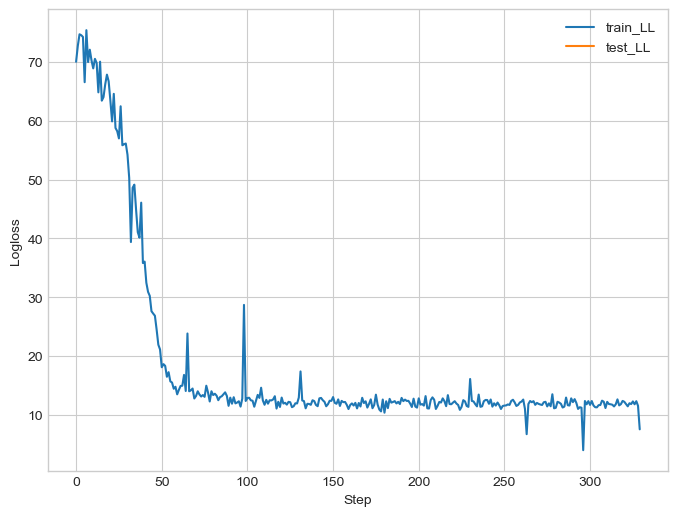

In [10]:
plot_training_logs(model)

Overall loss

In [11]:
print(calculate_loss(model, outcome_cols, dataloader_train))
print(calculate_loss(model, outcome_cols, dataloader_test))

[{'col': 'temperature', 'mse': 11.870365142822266}]
[{'col': 'temperature', 'mse': 11.862138748168945}]


Plot predictions

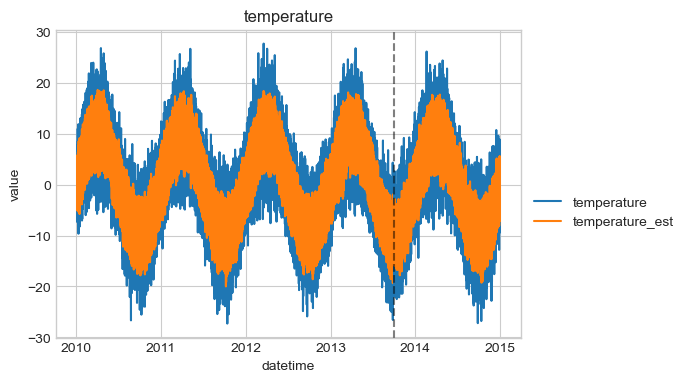

In [12]:
df_train_est = get_predictions(df_train, model, feature_cols, outcome_cols)
df_test_est = get_predictions(df_test, model, feature_cols, outcome_cols)
plot_predictions(df_train_est, df_test_est, outcome_cols)

#### Single outcome models

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus 

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_l

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_l

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",7.669838
"""humidity""","""train""","""humidity""",7.4959
"""temperature""","""test""","""temperature""",11.912771
"""temperature""","""train""","""temperature""",11.913651
"""wind_speed""","""test""","""wind_speed""",3.299239
"""wind_speed""","""train""","""wind_speed""",3.247031


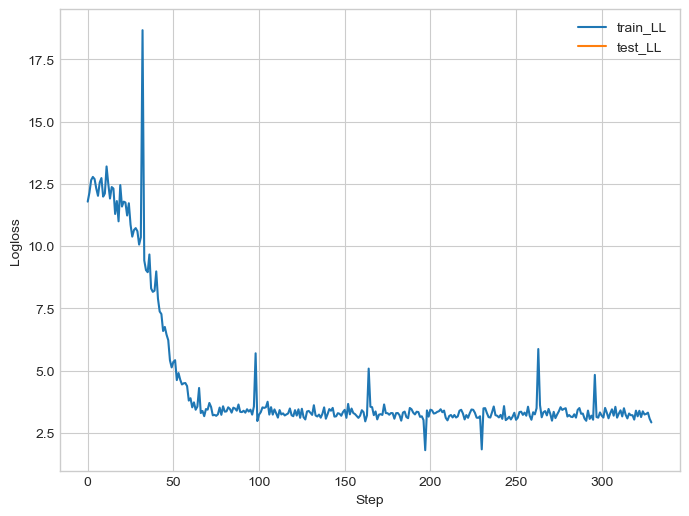

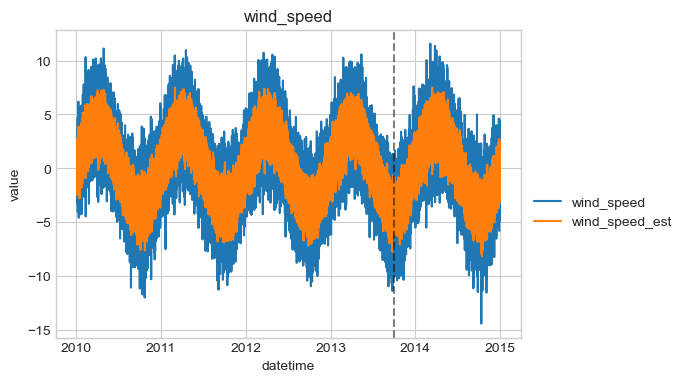

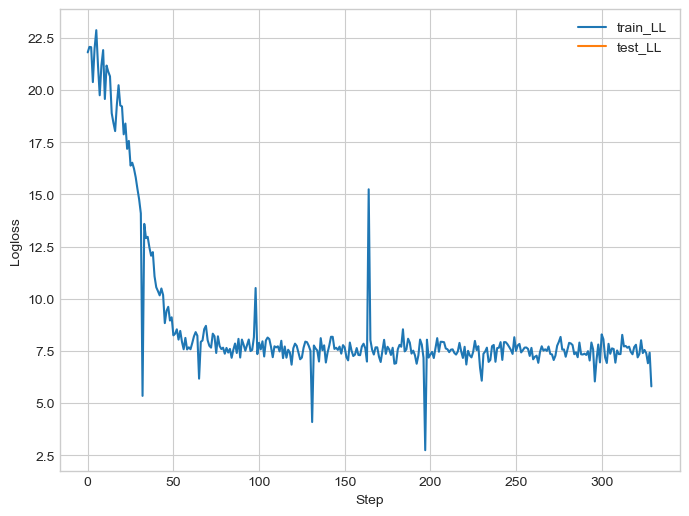

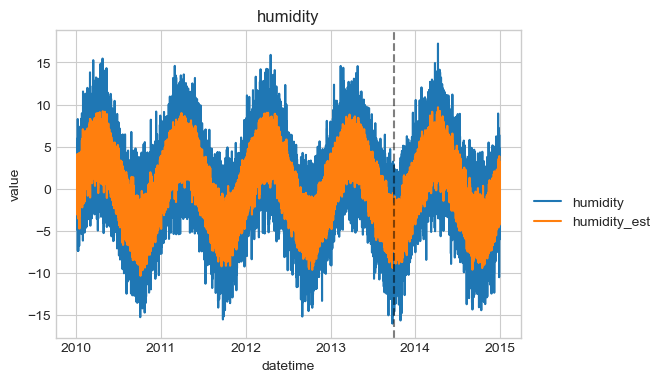

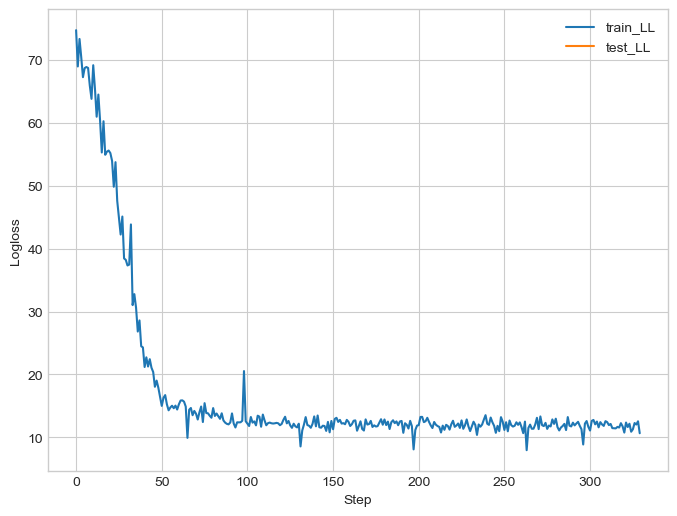

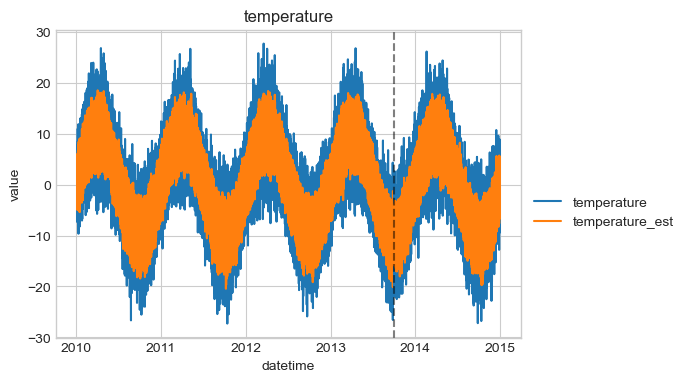

In [13]:
outcome_groups = [
    ["wind_speed"],
    ["humidity"],
    ["temperature"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=True,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_single_output = pl.DataFrame(losses)
losses_single_output.sort(["col", "fold", "outcome_cols"])

We can fit each time series by itself fine.

#### Testing multiple outcomes

Adding another output, does it improve loss on the first outcome?

Humidity/windspeed are based on temp, so include temp as a second outcome.
We will model wind speed and aim to improve its predictions by considering humidity and temperature.

In [14]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        debug=False,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/en

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",3.32864
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",3.145207
"""wind_speed""","""test""","""wind_speed""",3.301163
"""humidity_wind_speed""","""train""","""wind_speed""",3.252562
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",3.086034
"""wind_speed""","""train""","""wind_speed""",3.244651


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/1659394447.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


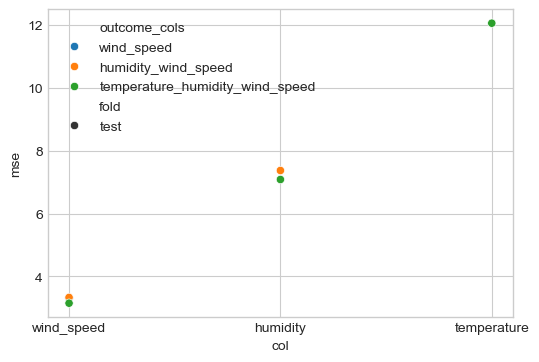

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
fig.show()

Add more outcomes has made the performance on wind_speed worse

### Wider network

In [16]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
            hidden_dim=[128, 64, 32, 16],
        ),
        debug=False,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 12.0 K
1 | loss | MSELoss    | 0     
------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",3.294437
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",3.116579
"""wind_speed""","""test""","""wind_speed""",3.284339
"""humidity_wind_speed""","""train""","""wind_speed""",3.232399
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",3.054983
"""wind_speed""","""train""","""wind_speed""",3.215989


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/1659394447.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


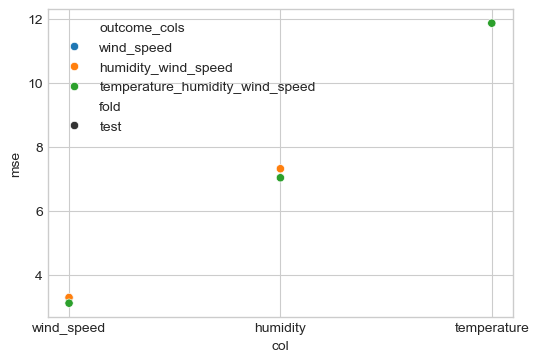

In [17]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
fig.show()

With a larger network including temperature and humidity makes test performance marginally better. Including humidity made it worse.

### Output weighting

In [18]:
class OutputWeightedMLP(SimpleMLP):
    def __init__(
        self,
        output_weighting: List[float] = None,
        output_dim: int = 1,
        **kwargs,
    ):
        if output_weighting is None:
            output_weighting = [1 / output_dim] * output_dim
        self.output_weighting = output_weighting
        self.output_dim = output_dim

        super().__init__(output_dim=output_dim, **kwargs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)

        loss = sum(
            [
                self.output_weighting[idx] * self.loss(y[:, idx], y_est[:, idx])
                for idx in range(self.output_dim)
            ]
        )

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)

        loss = sum(
            [
                self.output_weighting[idx] * self.loss(y[:, idx], y_est[:, idx])
                for idx in range(self.output_dim)
            ]
        )

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

In [19]:
outcome_cols = ["wind_speed", "temperature"]
weighting_groups = [[1.0, 0.0], [0.5, 0.5], [0.0, 0.1]]
losses = []
for output_weighting in weighting_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: OutputWeightedMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
            output_weighting=output_weighting,
        ),
        debug=False,
    )
    losses.extend(
        [
            {
                "outcome_cols": "_".join(outcome_cols),
                "output_weighting": str(output_weighting),
                "fold": "train",
                **loss,
            }
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {
                "outcome_cols": "_".join(outcome_cols),
                "output_weighting": str(output_weighting),
                "fold": "test",
                **loss,
            }
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols", "output_weighting"]).filter(pl.col("col") == "wind_speed")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.7 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

outcome_cols,output_weighting,fold,col,mse
str,str,str,str,f64
"""wind_speed_temperature""","""[0.0, 0.1]""","""test""","""wind_speed""",17.900496
"""wind_speed_temperature""","""[0.5, 0.5]""","""test""","""wind_speed""",3.169505
"""wind_speed_temperature""","""[1.0, 0.0]""","""test""","""wind_speed""",3.116389
"""wind_speed_temperature""","""[0.0, 0.1]""","""train""","""wind_speed""",21.694445
"""wind_speed_temperature""","""[0.5, 0.5]""","""train""","""wind_speed""",3.124877
"""wind_speed_temperature""","""[1.0, 0.0]""","""train""","""wind_speed""",3.056559


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/4171351163.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


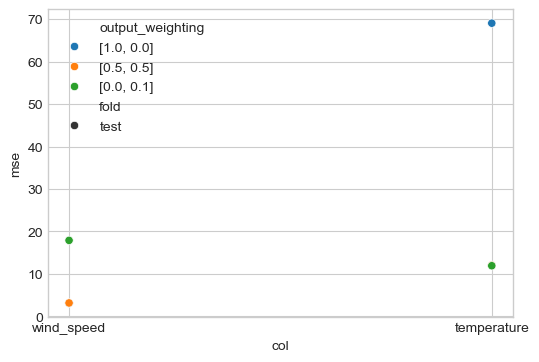

In [20]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="output_weighting",
    style="fold",
    ax=ax,
)
fig.show()

### Separate output heads

In [21]:
class OutputHeadsMLP(pyl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: List[int] = None,
        output_dim: int = 1,
        learning_rate=1e-3,
    ):
        super().__init__()

        if hidden_dim is None:
            hidden_dim = [32, 16, 16, 16]

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim[0]),
            nn.ReLU(),
            nn.Linear(hidden_dim[0], hidden_dim[1]),
            nn.ReLU(),
            nn.Linear(hidden_dim[1], hidden_dim[2]),
            nn.ReLU(),
            nn.Linear(hidden_dim[2], hidden_dim[3]),
        )
        self.output_layers = nn.ModuleList(
            [nn.Linear(hidden_dim[3], 1) for _ in range(output_dim)]
        )
        self.loss = nn.MSELoss()
        self.log_train = []
        self.log_val = []
        self.learning_rate = learning_rate

    def forward(self, x):
        emb = self.encoder(x)
        outputs = [output_layer(emb) for output_layer in self.output_layers]
        return torch.concat(outputs, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)  # averages over all outcomes equally

        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_est = self.forward(x)
        loss = self.loss(y, y_est)

        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())
        return loss

In [22]:
outcome_groups = [
    ["wind_speed"],
    ["humidity", "wind_speed"],
    ["temperature", "humidity", "wind_speed"],
]
losses = []
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: OutputHeadsMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
            hidden_dim=[128, 64, 32, 16],
        ),
        debug=False,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses = pl.DataFrame(losses)
losses.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 12.0 K
1 | output_layers | ModuleList | 17    
2 | loss          | MSELoss    | 0     
---------------------------------------------
12.0 K    Trainable params
0         Non-trainable params
12.0 K    Total params
0.048     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers 

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity_wind_speed""","""test""","""wind_speed""",3.281219
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",3.131969
"""wind_speed""","""test""","""wind_speed""",3.284582
"""humidity_wind_speed""","""train""","""wind_speed""",3.22472
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",3.070907
"""wind_speed""","""train""","""wind_speed""",3.21685


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/1659394447.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


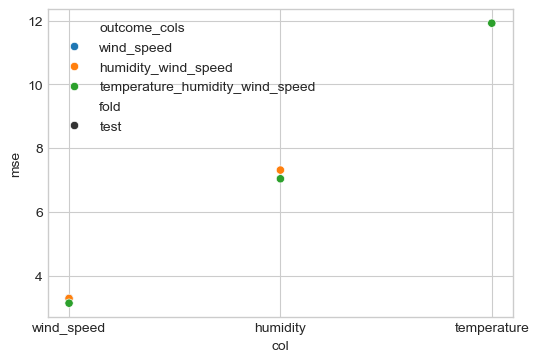

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    data=losses.filter(pl.col("fold") == "test"),
    x="col",
    y="mse",
    hue="outcome_cols",
    style="fold",
    ax=ax,
)
fig.show()

### Less data

Does the performance on the wind speed model already saturate with our data length?
If so, can we reduce and expect better gains from multi task learning?

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.4 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",19.757484
"""humidity""","""train""","""humidity""",0.984848
"""temperature""","""test""","""temperature""",17.598377
"""temperature""","""train""","""temperature""",5.497708
"""wind_speed""","""test""","""wind_speed""",7.634361
"""wind_speed""","""train""","""wind_speed""",0.794414


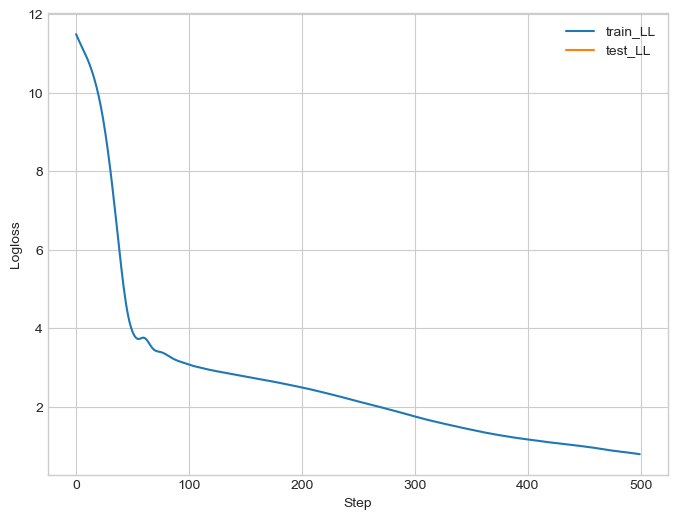

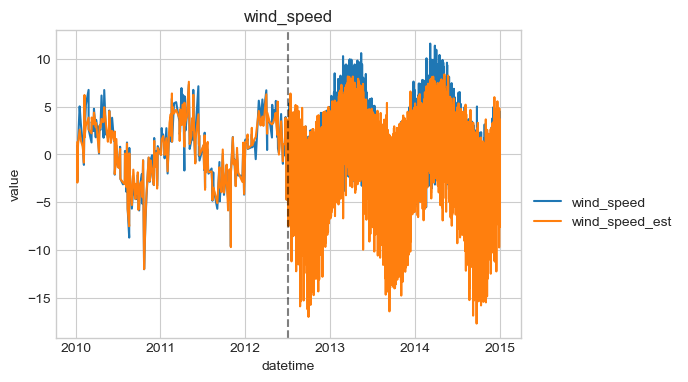

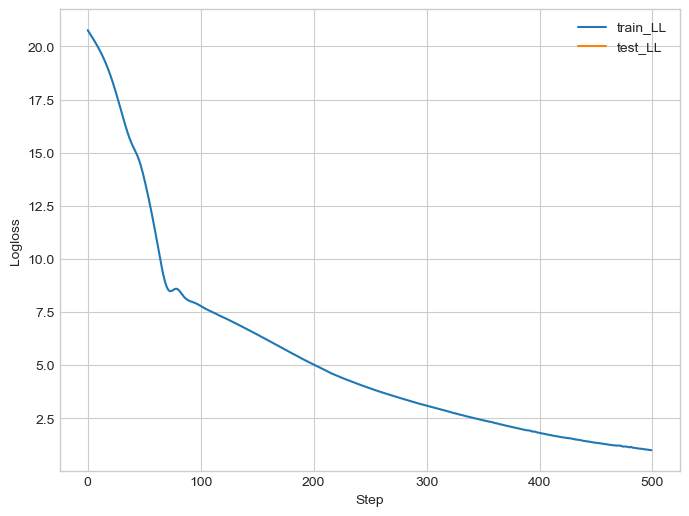

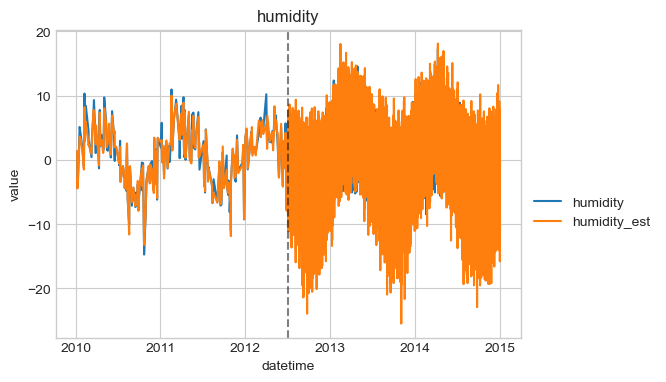

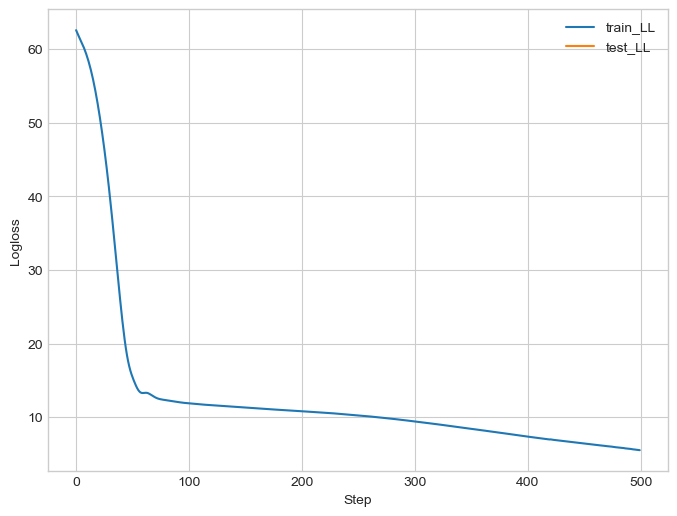

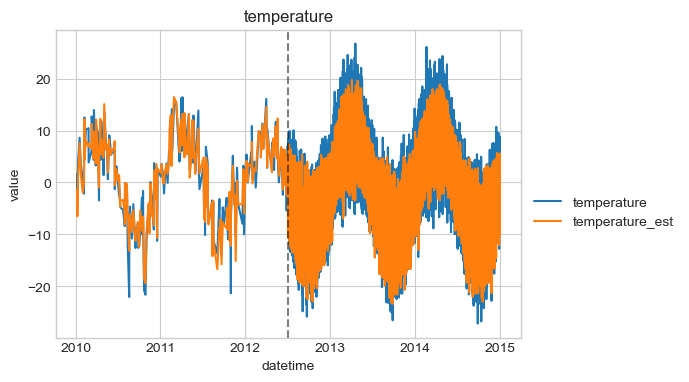

In [24]:
outcome_groups = [
    ["wind_speed"],
    ["humidity"],
    ["temperature"],
]
losses = []
np.random.seed(0)
df_train = (
    df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(frac=0.01).reset_index(drop=True)
)
df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :].reset_index(drop=True)
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        df_train=df_train,
        df_test=df_test,
        debug=True,
        epochs=500,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_less_data = pl.DataFrame(losses)
losses_less_data.sort(["col", "fold", "outcome_cols"])

Fitting on a much smaller sample creates worse models.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/stantoon/miniconda3/en

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2552816156.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


outcome_cols,fold,col,mse
str,str,str,f64
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",4.878296
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.506252


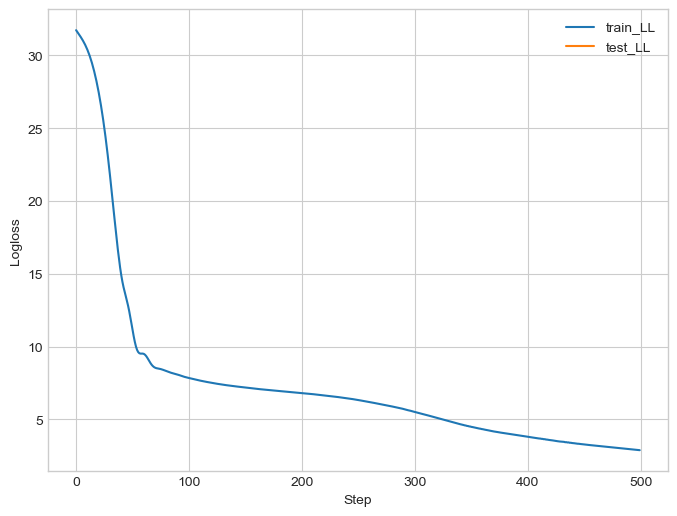

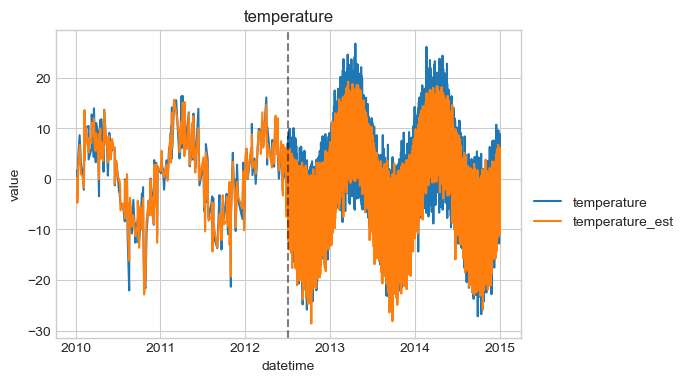

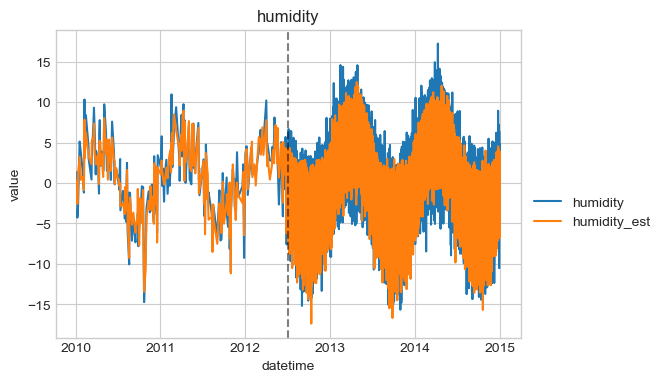

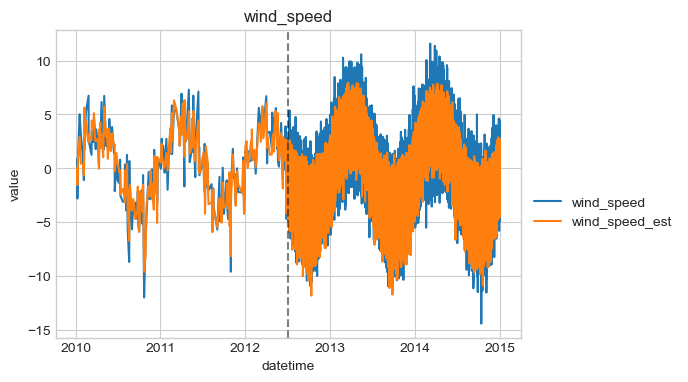

In [25]:
outcome_groups = [
    ["temperature", "humidity", "wind_speed"],
]
losses = []
np.random.seed(0)
df_train = (
    df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(frac=0.01).reset_index(drop=True)
)
df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :].reset_index(drop=True)
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        df_train=df_train,
        df_test=df_test,
        debug=True,
        epochs=500
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_combined_model = pl.DataFrame(losses)
losses_combined_model.sort(["col", "fold", "outcome_cols"]).filter(pl.col("col") == "wind_speed")

Comparing results

In [26]:
display(losses_single_output.sort(["col", "fold", "outcome_cols"]))
display(losses_less_data.sort(["col", "fold", "outcome_cols"]))
display(losses_combined_model.sort(["col", "fold", "outcome_cols"]))

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",7.669838
"""humidity""","""train""","""humidity""",7.4959
"""temperature""","""test""","""temperature""",11.912771
"""temperature""","""train""","""temperature""",11.913651
"""wind_speed""","""test""","""wind_speed""",3.299239
"""wind_speed""","""train""","""wind_speed""",3.247031


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",19.757484
"""humidity""","""train""","""humidity""",0.984848
"""temperature""","""test""","""temperature""",17.598377
"""temperature""","""train""","""temperature""",5.497708
"""wind_speed""","""test""","""wind_speed""",7.634361
"""wind_speed""","""train""","""wind_speed""",0.794414


outcome_cols,fold,col,mse
str,str,str,f64
"""temperature_humidity_wind_spee…","""test""","""humidity""",11.621401
"""temperature_humidity_wind_spee…","""train""","""humidity""",3.168034
"""temperature_humidity_wind_spee…","""test""","""temperature""",21.19767
"""temperature_humidity_wind_spee…","""train""","""temperature""",3.952404
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",4.878296
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.506252


Multi tasks generally improve performance. Temperature does not improve on test sets... this is likely due to temperature being derived separately, whereas humidity is derived from temperature and wind speed is derived from both.

Is this due to the lagged features or the extra outcome prediction tasks?

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2631224392.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2631224392.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 1.9 K 
1 | loss | MSELoss    | 0     
------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.008     Total estimated model params size (MB)
/Users/stantoon/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_24166/2631224392.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


outcome_cols,fold,col,mse
str,str,str,f64
"""wind_speed""","""test""","""wind_speed""",9.432172
"""wind_speed""","""train""","""wind_speed""",0.095573


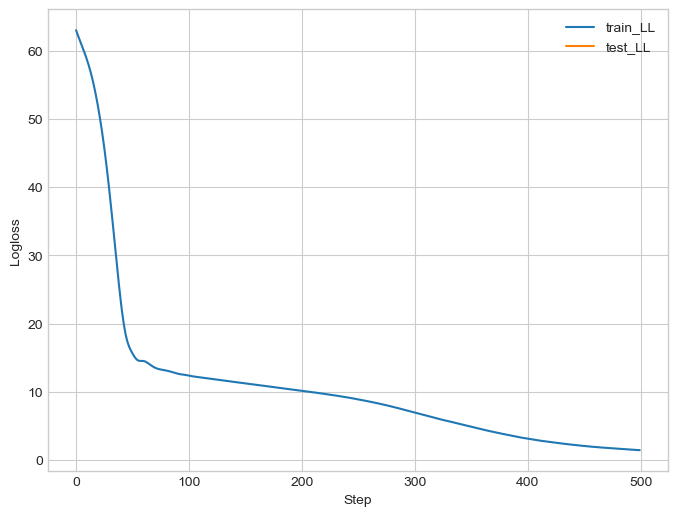

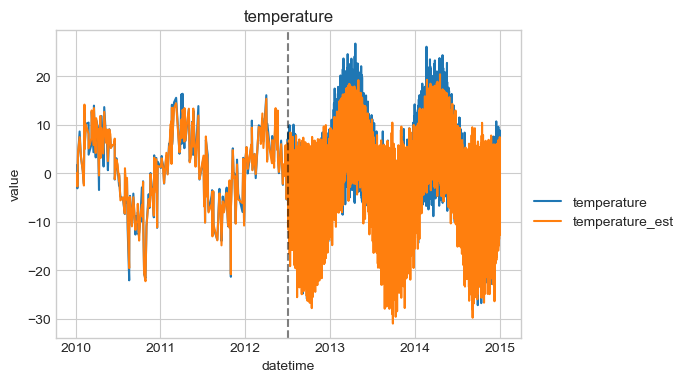

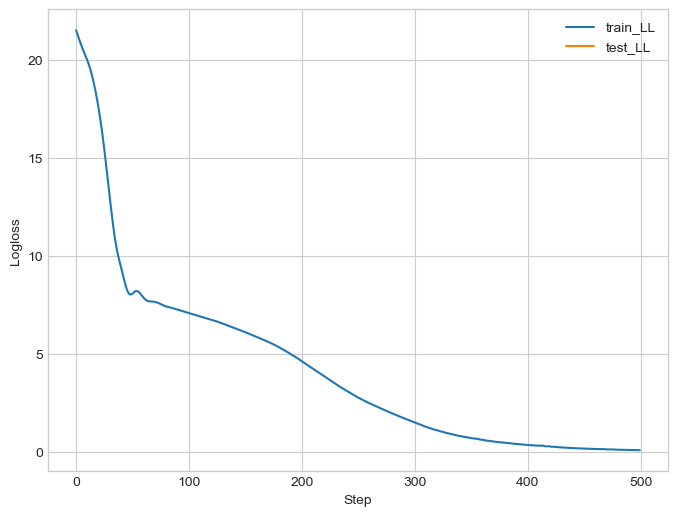

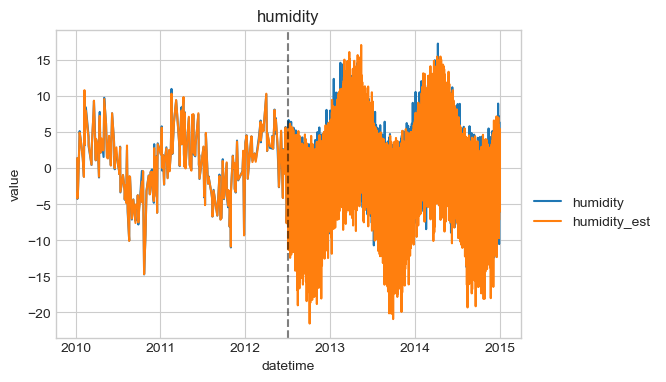

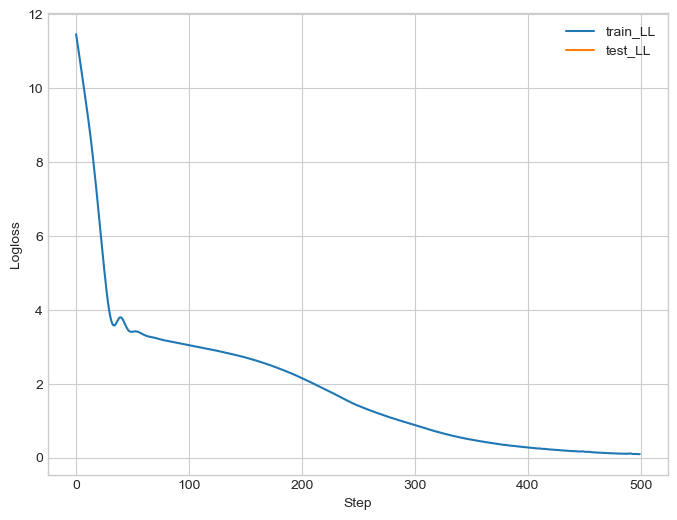

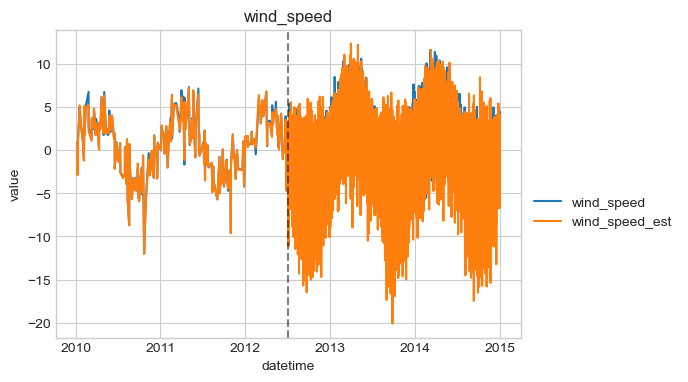

In [29]:
outcome_groups = [
    ["temperature"],
    ["humidity"],
    ["wind_speed"],
]
losses = []
np.random.seed(0)
df_train = (
    df_lagged[: int(df_lagged.shape[0] * 0.5)].sample(frac=0.01).reset_index(drop=True)
)
df_test = df_lagged[int(df_lagged.shape[0] * 0.5) :].reset_index(drop=True)
for outcome_cols in outcome_groups:
    loss_train, loss_test = loss_from_outcomes(
        outcome_cols=outcome_cols,
        feature_cols=get_features_from_outcomes(
            ["temperature", "humidity", "wind_speed"]
        ),
        model_callable=lambda feature_cols, outcome_cols: SimpleMLP(
            input_dim=len(feature_cols),
            output_dim=len(outcome_cols),
            learning_rate=1e-3,
        ),
        df_train=df_train,
        df_test=df_test,
        debug=True,
        epochs=500,
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "train", **loss}
            for loss in loss_train
        ]
    )
    losses.extend(
        [
            {"outcome_cols": "_".join(outcome_cols), "fold": "test", **loss}
            for loss in loss_test
        ]
    )

losses_all_features = pl.DataFrame(losses)
losses_all_features.sort(["col", "fold", "outcome_cols"])

Using all the features does not improve performance, its the additional tasks that matter as well.

In [30]:
display(losses_single_output.sort(["col", "fold", "outcome_cols"]))
display(losses_less_data.sort(["col", "fold", "outcome_cols"]))
display(losses_combined_model.sort(["col", "fold", "outcome_cols"]))
display(losses_all_features.sort(["col", "fold", "outcome_cols"]))

outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",7.669838
"""humidity""","""train""","""humidity""",7.4959
"""temperature""","""test""","""temperature""",11.912771
"""temperature""","""train""","""temperature""",11.913651
"""wind_speed""","""test""","""wind_speed""",3.299239
"""wind_speed""","""train""","""wind_speed""",3.247031


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",19.757484
"""humidity""","""train""","""humidity""",0.984848
"""temperature""","""test""","""temperature""",17.598377
"""temperature""","""train""","""temperature""",5.497708
"""wind_speed""","""test""","""wind_speed""",7.634361
"""wind_speed""","""train""","""wind_speed""",0.794414


outcome_cols,fold,col,mse
str,str,str,f64
"""temperature_humidity_wind_spee…","""test""","""humidity""",11.621401
"""temperature_humidity_wind_spee…","""train""","""humidity""",3.168034
"""temperature_humidity_wind_spee…","""test""","""temperature""",21.19767
"""temperature_humidity_wind_spee…","""train""","""temperature""",3.952404
"""temperature_humidity_wind_spee…","""test""","""wind_speed""",4.878296
"""temperature_humidity_wind_spee…","""train""","""wind_speed""",1.506252


outcome_cols,fold,col,mse
str,str,str,f64
"""humidity""","""test""","""humidity""",16.923826
"""humidity""","""train""","""humidity""",0.073299
"""temperature""","""test""","""temperature""",26.379261
"""temperature""","""train""","""temperature""",1.404004
"""wind_speed""","""test""","""wind_speed""",9.432172
"""wind_speed""","""train""","""wind_speed""",0.095573


# Appendix

Performance degrades when we add outcomes
* Has MSE converged? Yes
* Windspeed only model is likely best possible performance
  * We have enough data to optimise for windspeed alone.
* The model doesnt have expressiveness to model all outcomes in current architecture.
  * Increasing width - doesnt change performance
  * multi heads/deep/wider?
Different scales = different weighting in MSE
* Cross validate